## Inversion of 2x2 matrices Using a Feedforward Neural Network

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import timedelta

### Initialize
Import the feedforward and operator recurrent neural networks and the learning data from separate files.

In [2]:
import simple_nn
import opnet

from simple_inversion_data import generate_data, save_data, load_data
PATH = './simple_inversion_net_test.pth'  # define the path used to save trained parameters

PATH_OP = './simple_inversion_opnet_test.pth'

Initialize the parameters for the feedforward network.

In [3]:
dim = 4 # length of the data vector
num_nodes = 15 # the amount of the nodes in the linear layer between the input and output layers
model = simple_nn.NeuralNetwork(dim, num_nodes) # initialize the model
loss_fn = torch.nn.MSELoss()  # the loss function
l = 1e-1 # the learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=l) # optimization

Initialize the parameters for the operator recurrent network.

In [4]:
dim = 2; 
num_layers = 11;
model_op = opnet.OperatorNet(dim, num_layers)
loss_fn_op = torch.nn.MSELoss()  # the loss function
l_op = 1e-1 # the learning rate
optimizer_op = torch.optim.SGD(model_op.parameters(), lr=l_op) # optimization

### Generate the training data

In [5]:
# Since the data should be in different form for the feedforward network and the operator recurrent network,
# generate the data separately for both.
# see the code file for data generation and change accordingly

#save_data(*generate_data(60000), "simple_inversion_train_data.npz")
#save_data(*generate_data(10000), "simple_inversion_test_data.npz")

#save_data(*generate_data(60000), "for_opnet_simple_inversion_train_data.npz")
#save_data(*generate_data(10000), "for_opnet_simple_inversion_test_data.npz")

In [5]:
# Load the training data

# This for feedforward network
train_loader = torch.utils.data.DataLoader(
    load_data("simple_inversion_train_data.npz"),
    batch_size=64)

# This for operator network
train_loader_op = torch.utils.data.DataLoader(
    load_data("for_opnet_simple_inversion_train_data.npz"),
    
    batch_size=64)

### Train the data with feedforward network

In [7]:
# Check dimensions
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}") 
    break

for X, y in train_loader_op:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}") 
    break

Shape of X [N, C, H, W]: torch.Size([64, 4])
Shape of y: torch.Size([64, 2, 1]) torch.float32
Shape of X [N, C, H, W]: torch.Size([64, 2, 2])
Shape of y: torch.Size([64, 2, 1]) torch.float32


For the comparison of the networks check that the amount of learnable parameters is about the same.

In [6]:
#From: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

# check the amount of parameters
def count_parameters(model):
   
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        total_params+=params
    print(f"Total Trainable Params: {total_params}")
    #return total_params
    
count_parameters(model)
count_parameters(model_op)

Total Trainable Params: 107
Total Trainable Params: 110


Train the feedforward network.

In [6]:
losses = []
start = time.time()
# Loop over the training data
for epoch in range(5):
    
    print(f"Epoch {epoch+1}\n-------------------------------")
    running_loss = 0.0
    for batch, (X, y) in enumerate(train_loader):
        
    # Compute prediction error
    
        pred = model(X)   
        a2 = pred.unsqueeze(2)
        loss = loss_fn(a2, y)
        
        running_loss += loss.item() * X.size(0) # track losses to compute loss per epoch
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # Print statistics
        #if batch % 100 == 0:
          #  n, N = (batch + 1) * len(X), len(train_loader.dataset)
          #  print(f"loss: {loss.item():>7f}  [{n:>5d}/{N:>5d}]")
    #print(f"loss: {loss.item() /= len(train_loader):>7f} ")
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f" epoch_loss: {epoch_loss}") # print loss at the end of an epoch
    losses.append(epoch_loss)
    
    
torch.save(model.state_dict(), PATH)

end = time.time()
total_time = timedelta(seconds = end-start)
print(f'Total time: {total_time}')

Epoch 1
-------------------------------
 epoch_loss: 0.03289933071484168
Epoch 2
-------------------------------
 epoch_loss: 0.0031722747868547837
Epoch 3
-------------------------------
 epoch_loss: 0.001985991760902107
Epoch 4
-------------------------------
 epoch_loss: 0.0014685029271369178
Epoch 5
-------------------------------
 epoch_loss: 0.0012279949333518744
Total time: 0:00:04.103335


In [7]:
# Save the epoch losses of this iteration for plotting
#path= './epochlosses_ffn_400epochs_1hiddenlayer15_nodes_set3.pth'
#torch.save(losses,path)

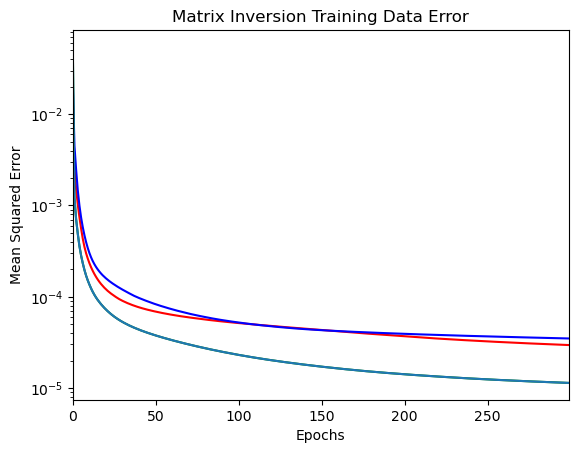

In [11]:
# load the epoch losses of previous trainings of the feedforward network
a = torch.load('epochlosses_ffn_300epochs_1hiddenlayer160_nodes_set1.pth')
b = torch.load('epochlosses_ffn_300epochs_1hiddenlayer160_nodes_set2.pth')
c = torch.load('epochlosses_ffn_300epochs_1hiddenlayer160_nodes_set3.pth')

# plot epoch losses from multiple iterations
plt.semilogy(a, 'r')
plt.semilogy(b, 'b')
plt.semilogy(c, 'g')


plt.semilogy(losses)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.xlim([0, 299])

plt.title(f'Matrix Inversion Training Data Error')

# Save the plot
#plt.savefig('mse_per_epochs_ffn_matrix_inv_300epochs_multiple_iter.jpg')

### Train the data with operator network

In [7]:
losses_opnet = []
start = time.time()
# Loop over the training data
for epoch in range(5):
    print(f"Epoch {epoch+1}\n-------------------------------")
    running_loss_op = 0.0
    for batch, (X_o, y_o) in enumerate(train_loader_op):
        
    # Compute prediction error
    
        pred_op = model_op(X_o)   
        loss_op = loss_fn_op(pred_op, y_o)
             
        running_loss_op += loss_op.item() * X_o.size(0) # track the losses to count loss per epoch
        
        # Backpropagation
        optimizer_op.zero_grad()
        loss_op.backward()
        optimizer_op.step()

        # Print statistics
        #if batch % 100 == 0:
         #   n, N = (batch + 1) * len(X_o), len(train_loader_op.dataset)
          #  print(f"loss: {loss_op.item():>7f}  [{n:>5d}/{N:>5d}]")
   # print(f"loss:{loss_op.item() /= len(train_loader_op):>7f}")

    epoch_loss_op = running_loss_op / len(train_loader_op.dataset)
    print(f" epoch_loss: {epoch_loss_op}") # print loss at the end of an epoch
    losses_opnet.append(epoch_loss_op)
    
    
torch.save(model_op.state_dict(), PATH_OP)
end = time.time()
total_time = timedelta(seconds = end-start)
print(f'Total time: {total_time}')

Epoch 1
-------------------------------
 epoch_loss: 0.025177314209689695
Epoch 2
-------------------------------
 epoch_loss: 0.005632366524885098
Epoch 3
-------------------------------
 epoch_loss: 0.004406026008290549
Epoch 4
-------------------------------
 epoch_loss: 0.0035401534913728633
Epoch 5
-------------------------------
 epoch_loss: 0.0028353937703495223
Total time: 0:00:20.053453


In [9]:
# Save the epoch losses of this run for plotting
#path = './epoch_losses_opnet_11_layers_400epochs_set1_trainingparams3.pth'
#torch.save(losses_opnet,path)

### Comparison of the Networks

Plot the losses of the feedforward network and operator recurrent network.

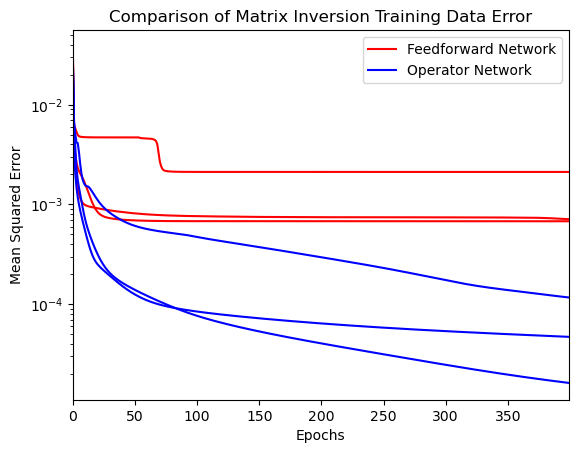

In [3]:
# load the example epoch loss of previous trainings of the feedforward network
a = torch.load('epochlosses_ffn_400epochs_1hiddenlayer15_nodes_set1.pth')
b = torch.load('epochlosses_ffn_400epochs_1hiddenlayer15_nodes_set1_trainingparams2.pth')
c = torch.load('epochlosses_ffn_400epochs_1hiddenlayer15_nodes_set1_trainingparams3.pth')

# load the example epoch loss of previous trainings of the operator network
e = torch.load('epoch_losses_opnet_11_layers_400epochs_set1.pth')
f = torch.load('epoch_losses_opnet_11_layers_400epochs_set1_trainingparams2.pth')
g = torch.load('epoch_losses_opnet_11_layers_400epochs_set1_trainingparams3.pth')


# plot the epoch losses
plt.semilogy(a, 'r', label = 'Feedforward Network')
plt.semilogy(b, 'r')
plt.semilogy(c, 'r')

plt.semilogy(e, 'b', label = 'Operator Network')
plt.semilogy(f, 'b')
plt.semilogy(g, 'b')

plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.xlim([0, 399])
plt.legend()
plt.title(f'Comparison of Matrix Inversion Training Data Error')

# Save the plot
#plt.savefig('mse_per_epochs_comparison_mat_inv_400epochs_multiple_iterations2.jpg')

### Test the data

If training of the network is already done, load the trained parameters.

In [6]:
## Load trained variables
model.load_state_dict(torch.load(PATH))

model_op.load_state_dict(torch.load(PATH_OP))

<All keys matched successfully>

In [8]:
# Load the testing data

# For shallow network
test_loader = torch.utils.data.DataLoader(
    load_data("simple_inversion_test_data.npz"),
    batch_size=64)

# For operator network
test_loader_op = torch.utils.data.DataLoader(
    load_data("for_opnet_simple_inversion_test_data.npz"),
    batch_size=64)


Calculate samples for comparison.

### Feedforward Neural Network

In [8]:
dataiter = iter(test_loader)
X, y = dataiter.next()
with torch.no_grad():
    pred = model(X).unsqueeze(2) 
print("True: ")
print(y[:2])
print("Prediction: ")
print(pred[:2])

True: 
tensor([[[1.1193],
         [0.5475]],

        [[1.0590],
         [0.9130]]])
Prediction: 
tensor([[[1.1320],
         [0.5198]],

        [[1.0367],
         [0.9221]]])


Calculate the average loss.

In [9]:
num_batches = len(test_loader)
test_loss = 0
with torch.no_grad():
    for X, y in test_loader:
        #pred = model(X.unsqueeze(1))
        #test_loss += loss_fn(pred.squeeze(1), y).item() # This for conv net
        pred = model(X)
        test_loss += loss_fn(pred.unsqueeze(2),y).item()
test_loss /= num_batches
print(f"Avg loss: {test_loss:>8f} \n")

Avg loss: 0.001007 



### Operator Network

In [12]:
dataiter_op = iter(test_loader_op)
X_o, y_o = dataiter_op.next()
with torch.no_grad():
    pred_op = model_op(X_o)
   
print("True: ")
print(y_o[:2])
print("Prediction: ")
print(pred_op[:2])

True: 
tensor([[[0.9665],
         [0.8736]],

        [[1.0381],
         [0.9456]]])
Prediction: 
tensor([[[0.9652],
         [0.8733]],

        [[1.0372],
         [0.9448]]])


Calculate the average loss

In [13]:
num_batches = len(test_loader_op)
test_loss_op = 0
with torch.no_grad():
    for X_o, y_o in test_loader_op:
        pred_op = model_op(X_o)
        test_loss_op += loss_fn_op(pred_op,y_o).item() 
test_loss_op /= num_batches
print(f"Avg loss: {test_loss_op:>8f} \n")

Avg loss: 0.000164 

